# Email Phishing Detection

This notebook uses the `phishing_email.csv` [dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?resource=download&select=phishing_email.csv), which combines six real-world email datasets into a single, unified format. Each record includes a `text_combined` column that merges the sender, subject, date, and email body into one text field, and a binary `label` where `1` indicates a phishing email and `0` a legitimate one.

The goal of this notebook is to explore the data, preprocess the text using NLP techniques, and train multiple machine learning models to classify phishing emails with high accuracy. Our target is to build a reliable model that achieves at least **95% accuracy** on the test set, making it suitable for deployment in a real-world detection system.

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Setup
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Plot Style
sns.set_style('dark')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emrev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emrev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emrev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\emrev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Exploratory Data Analysis (EDA)

In this section, we will load the `phishing_email.csv` dataset and perform initial exploration to understand its structure, check for missing values, and analyze the class distribution. This step helps us identify any potential issues in the data and ensures that we are working with a clean and balanced dataset before moving on to text preprocessing and model training.

**Load the Dataset**

In [2]:
df = pd.read_csv("../data/phishing_email.csv")
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [3]:
df.describe()

,label
count,82486.000000
mean,0.519979
std,0.499604
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


The dataset has `2` columns and `82486` rows.

In [5]:
df.isna().sum()

text_combined    0
label            0
dtype: int64

There are no `null` values.

In [6]:
print(df['label'].value_counts(normalize=True) * 100)

label
1    51.997915
0    48.002085
Name: proportion, dtype: float64


**Example of Emails**:

In [7]:
print("Legitimate Example:\n", df[df['label'] == 0]['text_combined'].iloc[0])

Legitimate Example:
 hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls


In [8]:
print("\nPhishing Example:\n", df[df['label'] == 1]['text_combined'].iloc[0])


Phishing Example:
 link dwl g 510 802 11 g wireless pci lan adapter 39 85 39 85 dwl g 510 high speed 2 4 ghz 802 11 g wireless pci lan adapter ieee 802 11 g standardupto 54 mbpsoperating frequency range 2 4 ghz ideal solution enabling wireless networking capabilities desktops pcs home office dwl g 510 visit http www computron com deals link dwl g 510 802 11 g wireless pci lan adapter link g 510 wireless pci adapter featuring latest ieee 802 11 g wireless technology deliverincredibly fast data transfer 2 4 ghz frequency g 510 features 802 11 g standard backwards compatible existing 802 11 11 b products already also offers 64 128 bit wep encryption includes removable antenna driver cd get link g 510 wireless pci lan adapter today general features pci interface removable antenna 64 128 bit wep encryption link act led plug play one stop distributorjebel ali duty free zonedubai uae www computron com latest clearance sale listing contact sales department limited quantities available selecte

**Visualization**:

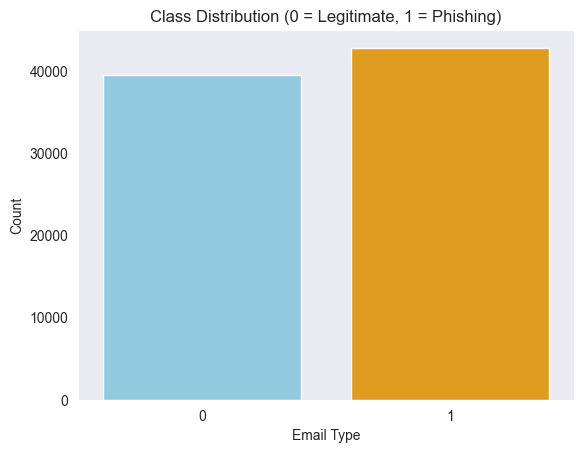

In [9]:
sns.countplot(data=df, x=df['label'], hue=df['label'], legend=False, palette={0: "skyblue", 1: "orange"})
plt.title('Class Distribution (0 = Legitimate, 1 = Phishing)')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

We have a balanced dataset! Now, it is time to check the length of the text!

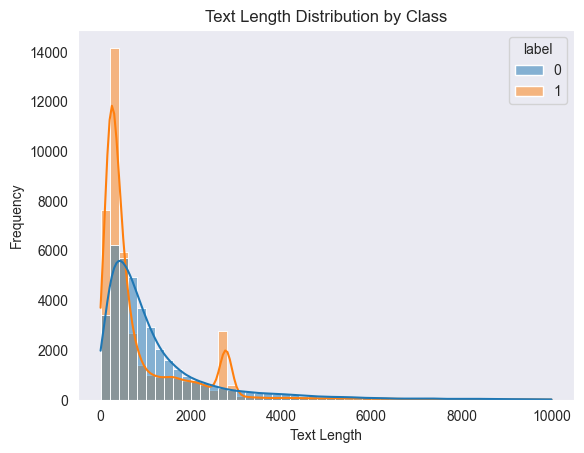

In [10]:
# Get the text length for each row
df['text_length'] = df['text_combined'].apply(len)

# Drop the data where the text length is more than 10k
filtered_df = df[df['text_length'] < 10000]

# Histogram
sns.histplot(data=filtered_df, x='text_length', hue='label', kde=True, bins=50)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

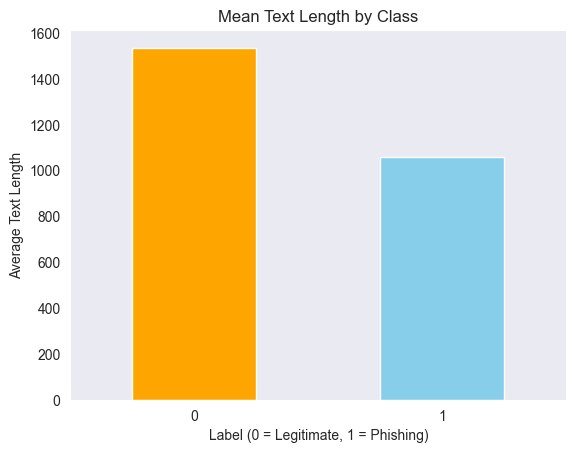

In [11]:
# Get the mean of the text length based on the label
mean_length = df.groupby('label')['text_length'].mean()

# Plot
mean_length.plot(kind='bar', color=['orange', 'skyblue'])
plt.title('Mean Text Length by Class')
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)')
plt.ylabel('Average Text Length')
plt.xticks(rotation=0)
plt.show()

From our analysis, we observe that **legitimate emails tend to be longer on average** than phishing emails. This trend is evident in both the mean text length and the overall length distribution. Phishing emails often prioritize urgency or simplicity, resulting in shorter messages with focused, manipulative content. In contrast, legitimate emails may contain more context, formal structure, and additional content like disclaimers or formatting.

These insights can be valuable for future feature engineering or anomaly detection strategies.

## Text Preprocessing

Before training any machine learning models, we need to clean and standardize the raw email text. In this section, we will preprocess the `text_combined` column by applying common NLP techniques such as lowercasing, removing punctuation and stopwords, and lemmatizing the words. This step ensures that the text data is in a consistent and simplified format, making it easier for models to learn meaningful patterns.

**Make it Lower Case**:

In [12]:
df['clean_text'] = df['text_combined'].str.lower()
df.head()

,text_combined,label,text_length,clean_text
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,hpl nom may 25 2001 see attached file hplno 52...
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,nom actual vols 24 th forwarded sabrae zajac h...
2,enron actuals march 30 april 1 201 estimated a...,0,148,enron actuals march 30 april 1 201 estimated a...
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,hpl nom may 30 2001 see attached file hplno 53...
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,hpl nom june 1 2001 see attached file hplno 60...


**Numbers and Punctuation**

In [13]:
def remove_punctuation_numbers(txt):
    txt = re.sub(r'\d+', '', txt) # Numbers
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # Punctuation
    txt = re.sub(r'\s+', ' ', txt) # Extra Spaces
    return txt

df['clean_text'] = df['clean_text'].apply(remove_punctuation_numbers)

In [14]:
df.head()

,text_combined,label,text_length,clean_text
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,0,148,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,hpl nom june see attached file hplno xls hplno...


**Stopwords**:

In [15]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(txt):
    tokens = txt.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['clean_text'] = df['clean_text'].apply(remove_stopwords)

In [16]:
df.head()

,text_combined,label,text_length,clean_text
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,0,148,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,hpl nom june see attached file hplno xls hplno...


**Lemmatization**:

In [17]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(txt):
    tokens = txt.split()
    lemmatized = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return ' '.join(lemmatized)

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

In [18]:
df.head()

,text_combined,label,text_length,clean_text
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,hpl nom may see attach file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,nom actual vols th forward sabrae zajac hou ec...
2,enron actuals march 30 april 1 201 estimated a...,0,148,enron actuals march april estimate actuals mar...
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,hpl nom may see attach file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,hpl nom june see attach file hplno xls hplno xls


We have successfully cleaned the raw email text to prepare it for machine learning. The preprocessing steps included converting all text to lowercase, removing punctuation and numbers, eliminating stopwords, and applying lemmatization to reduce words to their base forms. These steps help standardize the text data, reduce noise, and ensure that the model can focus on the most meaningful patterns for phishing detection.

## Feature Extraction and Model Training

In this section, we will convert the preprocessed email text into numerical features using the **TF-IDF** vectorization technique. This transforms the clean text into a format that machine learning models can understand. After vectorization, we will train and evaluate multiple classification models to detect phishing emails, including `Naive Bayes`, `Logistic Regression`, and `Support Vector Machines (SVM)`. Our goal is to identify a model that achieves strong accuracy and generalizes well to unseen data.

**Drop the Unnecessary Column**:

In [19]:
df = df[['clean_text', 'label']]
df.head()

,clean_text,label
0,hpl nom may see attach file hplno xls hplno xls,0
1,nom actual vols th forward sabrae zajac hou ec...,0
2,enron actuals march april estimate actuals mar...,0
3,hpl nom may see attach file hplno xls hplno xls,0
4,hpl nom june see attach file hplno xls hplno xls,0


**TF-IDF Vectorization**:

In [20]:
# Create Vectorizer
tfidf = TfidfVectorizer(max_features=5000) # Limit to top 5k important words

# Fit and Transform
X = tfidf.fit_transform(df['clean_text'])

# Target labels
y = df['label']

**Train & Test Split**:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Train Naive Bayes Classifier**:

In [25]:
# Initialize and Fit the Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Get the score
nb_score = nb_model.score(X_test, y_test)

# Get Predicts
y_pred_nb = nb_model.predict(X_test)

# Print the Score
print(f"Naive Bayes Base Model's Score: {nb_score}")

Naive Bayes Base Model's Score: 0.9580555218814402


Accuracy: 0.9580555218814402

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      7919
           1       0.98      0.94      0.96      8579

    accuracy                           0.96     16498
   macro avg       0.96      0.96      0.96     16498
weighted avg       0.96      0.96      0.96     16498



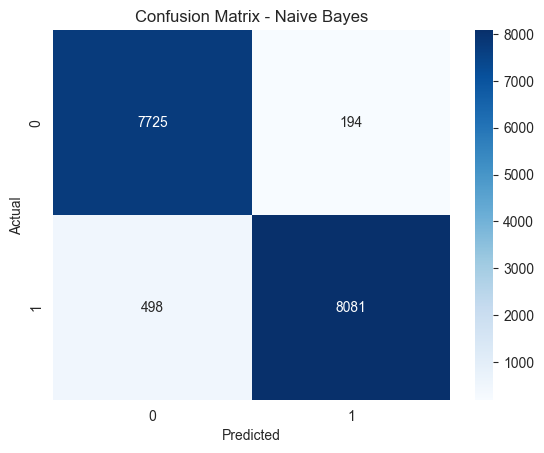

In [29]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We trained a Multinomial Naive Bayes model as a baseline classifier using TF-IDF features. The model achieved an accuracy of **95.8%**, with both classes showing high precision and recall. Legitimate emails (label 0) were predicted correctly 97.5% of the time, while phishing emails (label 1) had a recall of 94.2%. This strong baseline performance indicates that phishing emails can be effectively detected using simple NLP techniques and Naive Bayes. Next, we will evaluate a `Logistic Regression` model to see if we can further improve performance.